# Video Frame Interpolation and Motion Compression

## Introduction
This Python 3 notebook is used to develop deep neural network architectures that facilitate video compression at a standard comparable or superior to common hand tuned video codecs such as H.264. All DNN Architectures are developed using the Pytorch 1.0.1 framework. 

**Requirements:**
   - Pytorch 1.0.1
   - Torchvision
   - NVVL
   - ScikitVideo
   - ScikitImage
   - OpenCV
   - Pyplot
   - PIL
   
**Kush Gauge:** W x H x F x M x 0.07 where M = {1, 2, 4}

**Imports**

In [1]:
import os
import torch
import decimal
import subprocess as sub
from video_codec import EvalMVC
import utils.curves as curve_t
from evaluate import EvalVideoModel
from process_data import VideoDataLoaders
from image_networks import ImageVAE
from video_networks import VideoAuto, PFrameVideoAuto, BFrameVideoAuto, VideoVAE

**Helper Functions**

In [2]:
"""
Function : run_cmd
    
    runs a python script from within python and prints stdout to screen in real-time
    
    Args:
        cmd (string) : command to run as subprocess
        
    Ref: https://stackoverflow.com/questions/17411966/
"""

def run_cmd(cmd):
    
    # create subprocess
    proc = sub.Popen(cmd, stdout=sub.PIPE, universal_newlines=True)
    
    # read output line for line
    while proc.poll() is None:
        
        opt = proc.stdout.readline()
        print(opt)
    
    # print rest of output
    print(proc.stdout.read()) 
    return

"""
Function : float_to_str
    
    converts float to string without using scientific notation

"""

def float_to_str(f):
    ctx = decimal.Context()
    ctx.prec = 20
    d1 = ctx.create_decimal(repr(f))
    return format(d1, 'f')

## Data & Preprocessing

The Hollywood Dataset is used for training, validation and test data during model development.

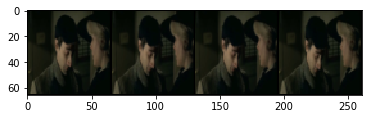

In [3]:
# create video dataLoaders
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(64, 64), 
    n_gop=4, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space = 'RGB'
)
# display frames
vdls.display_gop('valid', widget=False)

## Video Inter-Frame Prediction Networks

<img src="files/model_diag/vid_net.png">

### Video Autoencoder (0.015625 bpp)
3D Convolutional Autonecoder that encodes video frames to a lower dimension discrete latent space (using STE binarisation) from which it aims to reconstruct the original video sequence.

**Train Model**

In [3]:
# train script cmd
cmd = [
    'python'            , 'train.py',
    '--sys'             , 'VideoAuto',
    '--epochs'          , '150',
    '--learn_rate'      , '0.0001',
    '--gamma'           , '0.1',
    '--log'             , './logs/VideoAuto',
    '--train'           , '~/Videos/hollywood',
    '--save'            , './saved_models/VideoAuto',
    '--frame_size'      , '64',
    '--batch_size'      , '3',
    '--bottleneck_depth', '8',
    '--n_gop'           , '16',
    '--vid_ext'         , '.mp4',
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

Training New System : 

Epoch 1/150

--------------------------------------

Phase: train Loss : 0.12449116721483214

Phase: valid Loss : 0.05033202948314803

Epoch time: 1.0405900438626607 min

-------------------------------------

Epoch 2/150

--------------------------------------

Phase: train Loss : 0.058439837183271136

Phase: valid Loss : 0.038221338763833046

Epoch time: 0.988995905717214 min

-------------------------------------

Epoch 3/150

--------------------------------------

Phase: train Loss : 0.052842643105291895

Phase: valid Loss : 0.03725048074764865

Epoch time: 0.9834205071131389 min

-------------------------------------

Epoch 4/150

--------------------------------------

Phase: train Loss : 0.04719310121477715

Phase: valid Loss : 0.03665026490177427

Epoch time: 0.9814906160036723 min

-------------------------------------

Epoch 5/150

--------------------------------------

Phase: train Loss : 0.0423036423179188

Phase: valid Loss : 0.03374669115458216



Phase: train Loss : 0.02663021168139364

Phase: valid Loss : 0.019662740507296154

Epoch time: 0.9873410860697428 min

-------------------------------------

Epoch 41/150

--------------------------------------

Phase: train Loss : 0.02564434208907187

Phase: valid Loss : 0.019756850520414964

Epoch time: 0.9870311657587687 min

-------------------------------------

Epoch 42/150

--------------------------------------

Phase: train Loss : 0.026702362059482506

Phase: valid Loss : 0.019695979676076343

Epoch time: 0.9936171332995097 min

-------------------------------------

Epoch 43/150

--------------------------------------

Phase: train Loss : 0.02574457263440958

Phase: valid Loss : 0.019318259454199245

Epoch time: 0.9909320990244548 min

-------------------------------------

Epoch 44/150

--------------------------------------

Phase: train Loss : 0.025367286069584744

Phase: valid Loss : 0.019301536892141615

Epoch time: 0.9884104092915853 min

-------------------------------

Phase: train Loss : 0.02585067270390157

Phase: valid Loss : 0.018451200665107796

Epoch time: 0.989142922560374 min

-------------------------------------

Epoch 80/150

--------------------------------------

Phase: train Loss : 0.02505958955402353

Phase: valid Loss : 0.019248869669224535

Epoch time: 0.9818682591120402 min

-------------------------------------

Epoch 81/150

--------------------------------------

Phase: train Loss : 0.025698357318261904

Phase: valid Loss : 0.018700894500528063

Epoch time: 1.007435941696167 min

-------------------------------------

Epoch 82/150

--------------------------------------

Phase: train Loss : 0.024966403090261987

Phase: valid Loss : 0.01889963142041649

Epoch time: 0.9987035592397054 min

-------------------------------------

Epoch 83/150

--------------------------------------

Phase: train Loss : 0.024683140271476337

Phase: valid Loss : 0.018713282022093023

Epoch time: 0.9908783356348674 min

---------------------------------

Phase: train Loss : 0.02465066961678011

Phase: valid Loss : 0.018429690040647984

Epoch time: 1.0040078202883402 min

-------------------------------------

Epoch 119/150

--------------------------------------

Phase: train Loss : 0.0244234467856586

Phase: valid Loss : 0.018497588645134653

Epoch time: 1.0014356096585593 min

-------------------------------------

Epoch 120/150

--------------------------------------

Phase: train Loss : 0.025046640315226146

Phase: valid Loss : 0.018466819876006672

Epoch time: 0.9845535278320312 min

-------------------------------------

Epoch 121/150

--------------------------------------

Phase: train Loss : 0.024828857728945358

Phase: valid Loss : 0.018795284841741835

Epoch time: 0.9885540286699931 min

-------------------------------------

Epoch 122/150

--------------------------------------

Phase: train Loss : 0.024124420527368785

Phase: valid Loss : 0.01855196976768119

Epoch time: 0.9639695167541504 min

----------------------------

**DataLoader**

In [3]:
# def Video Dataloader
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(64, 64), 
    n_gop=16, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

**Qualitative Evaluation:**

In [4]:
# def Video Autoencoder
video_auto = VideoAuto(
    bnd=8
)

# load model weights
video_auto.load_model("./saved_models/VideoAuto/VideoAuto.pt")

# display compressed vs reference frames
ev = EvalVideoModel(video_auto, vdls, standard_epe=False)
ev.compare_frames('valid', widget=True)

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

PSNR : 27.558929443359375
SSIM : 0.7256535887718201
VMAF : 57.314028
EPE  : 0.19836054742336273


**Average Stats**

In [5]:
# display average stats
ev.disp_avg_stats("valid")

PSNR : 23.712152624130248
SSIM : 0.641178548336029
VMAF : 41.210275125
EPE  : 0.49267157912254333


### P-Frame Video Auto (0.015625 bpp)

<img src="files/model_diag/pf_auto.png">

**Train Model**

In [3]:
# train script cmd
cmd = [
    'python'            , 'train.py',
    '--sys'             , 'PFrameVideoAuto',
    '--epochs'          , '150',
    '--learn_rate'      , '0.0001',
    '--gamma'           , '0.1',
    '--log'             , './logs/PFrameVideoAuto/8bnd',
    '--train'           , '~/Videos/hollywood',
    '--save'            , './saved_models/PFrameVideoAuto/8bnd',
    '--frame_size'      , '64',
    '--batch_size'      , '3',
    '--bottleneck_depth', '8',
    '--n_gop'           , '17',
    '--vid_ext'         , '.mp4',
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

Training New System : 

Epoch 1/150

--------------------------------------

Phase: train Loss : 0.08463204362030541

Phase: valid Loss : 0.03929611543814341

Epoch time: 1.102201016743978 min

-------------------------------------

Epoch 2/150

--------------------------------------

Phase: train Loss : 0.048314576223492625

Phase: valid Loss : 0.035636156176527344

Epoch time: 1.135562578837077 min

-------------------------------------

Epoch 3/150

--------------------------------------

Phase: train Loss : 0.03848478915835066

Phase: valid Loss : 0.03599111270159483

Epoch time: 1.0024357755978903 min

-------------------------------------

Epoch 4/150

--------------------------------------

Phase: train Loss : 0.04047797459643334

Phase: valid Loss : 0.03237818173753718

Epoch time: 1.0332298835118612 min

-------------------------------------

Epoch 5/150

--------------------------------------

Phase: train Loss : 0.036922987324318715

Phase: valid Loss : 0.027798387066771586


Phase: train Loss : 0.014373238115305347

Phase: valid Loss : 0.01266401786900436

Epoch time: 1.0235520402590434 min

-------------------------------------

Epoch 41/150

--------------------------------------

Phase: train Loss : 0.014845094231090376

Phase: valid Loss : 0.012739607132971287

Epoch time: 1.0175457318623862 min

-------------------------------------

Epoch 42/150

--------------------------------------

Phase: train Loss : 0.013429586291645786

Phase: valid Loss : 0.012735634615334371

Epoch time: 0.9971731901168823 min

-------------------------------------

Epoch 43/150

--------------------------------------

Phase: train Loss : 0.015089665705870305

Phase: valid Loss : 0.012669151416048408

Epoch time: 1.0061070521672566 min

-------------------------------------

Epoch 44/150

--------------------------------------

Phase: train Loss : 0.01613465978880413

Phase: valid Loss : 0.012773029874855032

Epoch time: 1.000100274880727 min

-------------------------------

Phase: train Loss : 0.013820867528141077

Phase: valid Loss : 0.011990412080194801

Epoch time: 1.047616453965505 min

-------------------------------------

Epoch 80/150

--------------------------------------

Phase: train Loss : 0.013029115400942308

Phase: valid Loss : 0.012312595189238587

Epoch time: 1.00005784034729 min

-------------------------------------

Epoch 81/150

--------------------------------------

Phase: train Loss : 0.014718834586840654

Phase: valid Loss : 0.012199038678469757

Epoch time: 1.0160317103068033 min

-------------------------------------

Epoch 82/150

--------------------------------------

Phase: train Loss : 0.013851263877170693

Phase: valid Loss : 0.01228076060457776

Epoch time: 1.0079343835512797 min

-------------------------------------

Epoch 83/150

--------------------------------------

Phase: train Loss : 0.01317369908792898

Phase: valid Loss : 0.01195494537629808

Epoch time: 1.0065725723902383 min

----------------------------------

Phase: train Loss : 0.01392804544718404

Phase: valid Loss : 0.011893943204389265

Epoch time: 0.9888229171435038 min

-------------------------------------

Epoch 119/150

--------------------------------------

Phase: train Loss : 0.013223369216679463

Phase: valid Loss : 0.011985878207876036

Epoch time: 1.0103246132532755 min

-------------------------------------

Epoch 120/150

--------------------------------------

Phase: train Loss : 0.013316510043971773

Phase: valid Loss : 0.012948181751805047

Epoch time: 1.0252773324648539 min

-------------------------------------

Epoch 121/150

--------------------------------------

Phase: train Loss : 0.013172012767920802

Phase: valid Loss : 0.012391277511293689

Epoch time: 1.024279812971751 min

-------------------------------------

Epoch 122/150

--------------------------------------

Phase: train Loss : 0.01279944149511201

Phase: valid Loss : 0.011917137385656437

Epoch time: 1.0094500263532002 min

---------------------------

**DataLoader**

In [3]:
# def Video Dataloader
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(640, 640), 
    n_gop=17, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

**Qualitative Evaluation**

In [4]:
# def Video Autoencoder
pf_video_auto = PFrameVideoAuto(
    bnd=8
)

# load model weights
pf_video_auto.load_model("./saved_models/PFrameVideoAuto/8bnd/PFrameVideoAuto.pt")

# display compressed vs reference frames
ev = EvalVideoModel(pf_video_auto, vdls, standard_epe=False)
ev.compare_frames('valid', widget=True)

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

PSNR : 30.920215606689453
SSIM : 0.7775448560714722
VMAF : 45.66128
EPE  : 2.0123982429504395


**Average Stats**

In [14]:
# dosplay compression stats
ev.disp_avg_stats('valid')

PSNR : 28.25001277923584
SSIM : 0.8026221990585327
VMAF : 62.311287000000014
EPE  : 0.47697994112968445


### B-Frame Video Auto (0.015625 bpp)

<img src="files/model_diag/bf_auto.png">

**Train Model**

In [4]:
# train script cmd
cmd = [
    'python'            , 'train.py',
    '--sys'             , 'BFrameVideoAuto',
    '--epochs'          , '150',
    '--learn_rate'      , '0.0001',
    '--gamma'           , '0.1',
    '--log'             , './logs/BFrameVideoAuto/8bnd',
    '--train'           , '~/Videos/hollywood',
    '--save'            , './saved_models/BFrameVideoAuto/8bnd',
    '--frame_size'      , '64',
    '--batch_size'      , '3',
    '--bottleneck_depth', '8',
    '--n_gop'           , '18',
    '--vid_ext'         , '.mp4',
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

Training New System : 

Epoch 1/150

--------------------------------------

Phase: train Loss : 0.07081126598641277

Phase: valid Loss : 0.03275894823794564

Epoch time: 1.0149407982826233 min

-------------------------------------

Epoch 2/150

--------------------------------------

Phase: train Loss : 0.030343392035657807

Phase: valid Loss : 0.028632377739995718

Epoch time: 1.4054282506306965 min

-------------------------------------

Epoch 3/150

--------------------------------------

Phase: train Loss : 0.026590567092145127

Phase: valid Loss : 0.026605527382344007

Epoch time: 1.0349416732788086 min

-------------------------------------

Epoch 4/150

--------------------------------------

Phase: train Loss : 0.028131265249768538

Phase: valid Loss : 0.02749962507126232

Epoch time: 1.0045361916224163 min

-------------------------------------

Epoch 5/150

--------------------------------------

Phase: train Loss : 0.023104058412302817

Phase: valid Loss : 0.02303708367981

Phase: train Loss : 0.010434532714342432

Phase: valid Loss : 0.01000527604871119

Epoch time: 1.0139275272687276 min

-------------------------------------

Epoch 41/150

--------------------------------------

Phase: train Loss : 0.010904485487013256

Phase: valid Loss : 0.010070605640066788

Epoch time: 1.0222535769144694 min

-------------------------------------

Epoch 42/150

--------------------------------------

Phase: train Loss : 0.00993195340436484

Phase: valid Loss : 0.010005499925076341

Epoch time: 1.0444488326708476 min

-------------------------------------

Epoch 43/150

--------------------------------------

Phase: train Loss : 0.009931133868355703

Phase: valid Loss : 0.010060040901104609

Epoch time: 1.0163910110791525 min

-------------------------------------

Epoch 44/150

--------------------------------------

Phase: train Loss : 0.009981542160468442

Phase: valid Loss : 0.0110219931229949

Epoch time: 1.0077006181081136 min

--------------------------------

Phase: train Loss : 0.010112346318783239

Phase: valid Loss : 0.00958641390510214

Epoch time: 1.0063528259595236 min

-------------------------------------

Epoch 80/150

--------------------------------------

Phase: train Loss : 0.009741751677522968

Phase: valid Loss : 0.009461341745918617

Epoch time: 1.0116691827774047 min

-------------------------------------

Epoch 81/150

--------------------------------------

Phase: train Loss : 0.009222459817205422

Phase: valid Loss : 0.009545884735416621

Epoch time: 1.0019227584203085 min

-------------------------------------

Epoch 82/150

--------------------------------------

Phase: train Loss : 0.009135017354856246

Phase: valid Loss : 0.010265061224345118

Epoch time: 1.0149739344914754 min

-------------------------------------

Epoch 83/150

--------------------------------------

Phase: train Loss : 0.009759231833491607

Phase: valid Loss : 0.009514437716764709

Epoch time: 0.9979443828264872 min

-----------------------------

Phase: train Loss : 0.009277015414720933

Phase: valid Loss : 0.009382558171637356

Epoch time: 1.0031121850013733 min

-------------------------------------

Epoch 119/150

--------------------------------------

Phase: train Loss : 0.010160376175190323

Phase: valid Loss : 0.009383684509278586

Epoch time: 1.0154293060302735 min

-------------------------------------

Epoch 120/150

--------------------------------------

Phase: train Loss : 0.009895866339294505

Phase: valid Loss : 0.010493281840657195

Epoch time: 1.0198956370353698 min

-------------------------------------

Epoch 121/150

--------------------------------------

Phase: train Loss : 0.008995431270782969

Phase: valid Loss : 0.00953601774138709

Epoch time: 1.0055588603019714 min

-------------------------------------

Epoch 122/150

--------------------------------------

Phase: train Loss : 0.00955800439696759

Phase: valid Loss : 0.009391514681434879

Epoch time: 1.0158093293507895 min

--------------------------

**DataLoader**

In [5]:
# def Video Dataloader
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(64, 64), 
    n_gop=18, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

**Qualitative Evaluation**

In [6]:
# def Video Autoencoder
ms_bf_video_auto = BFrameVideoAuto(
    bnd=8,
    multiscale=True
)

# load model weights
ms_bf_video_auto.load_model("./saved_models/BFrameVideoAuto/Multiscale/8bnd/BFrameVideoAuto.pt")

# display compressed vs reference frames
ev = EvalVideoModel(ms_bf_video_auto, vdls, standard_epe=False)
ev.compare_frames('valid', widget=True)

interactive(children=(IntSlider(value=11, description='i', max=23), Output()), _dom_classes=('widget-interact'…

PSNR : 28.60327911376953
SSIM : 0.7809532284736633
VMAF : 36.606187
EPE  : 0.7423205971717834


**Average Stats**

In [5]:
ev.disp_avg_stats('valid')

PSNR : 29.814650058746338
SSIM : 0.8423969149589539
VMAF : 71.03221519999997
EPE  : 0.4772859513759613


### Flow Loss Experiment

<img src="files/model_diag/flow_setup.png">

#### Multiscale B-Frame Video Auto (0.015625 bpp)  with EPE Flow Loss

**Train Model**

In [4]:
# train script cmd
cmd = [
    'python'            , 'train.py',
    '--sys'             , 'BFrameVideoAuto',
    '--epochs'          , '150',
    '--learn_rate'      , '0.0001',
    '--gamma'           , '0.1',
    '--log'             , './logs/BFrameVideoAuto/FlowLoss/EPE/8bnd',
    '--train'           , '~/Videos/hollywood',
    '--save'            , './saved_models/BFrameVideoAuto/FlowLoss/EPE/8bnd',
    '--frame_size'      , '64',
    '--batch_size'      , '3',
    '--bottleneck_depth', '8',
    '--n_gop'           , '18',
    '--vid_ext'         , '.mp4',
    '--multiscale'      ,
    '--epe_flow_loss'   ,
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

Training New System : 

Epoch 1/150

--------------------------------------

Phase: train Loss : 0.0880941489775633

Phase: valid Loss : 0.03918939882091114

Epoch time: 2.5793148636817933 min

-------------------------------------

Epoch 2/150

--------------------------------------

Phase: train Loss : 0.035212989331319416

Phase: valid Loss : 0.030826013335692033

Epoch time: 2.5907612363497416 min

-------------------------------------

Epoch 3/150

--------------------------------------

Phase: train Loss : 0.030338692347165838

Phase: valid Loss : 0.029478445183485746

Epoch time: 2.6607884248097737 min

-------------------------------------

Epoch 4/150

--------------------------------------

Phase: train Loss : 0.027297607924917647

Phase: valid Loss : 0.025779565197548697

Epoch time: 2.580829612414042 min

-------------------------------------

Epoch 5/150

--------------------------------------

Phase: train Loss : 0.027485314955742194

Phase: valid Loss : 0.024608630587213

Phase: train Loss : 0.016734037331530248

Phase: valid Loss : 0.01730264804791659

Epoch time: 2.5764335791269937 min

-------------------------------------

Epoch 41/150

--------------------------------------

Phase: train Loss : 0.016306655976022114

Phase: valid Loss : 0.017215410147660544

Epoch time: 2.6051122824350994 min

-------------------------------------

Epoch 42/150

--------------------------------------

Phase: train Loss : 0.015201127704168703

Phase: valid Loss : 0.017094303953594396

Epoch time: 2.638994876543681 min

-------------------------------------

Epoch 43/150

--------------------------------------

Phase: train Loss : 0.01803879509840546

Phase: valid Loss : 0.01712803140149585

Epoch time: 2.57645583152771 min

-------------------------------------

Epoch 44/150

--------------------------------------

Phase: train Loss : 0.01753700434166039

Phase: valid Loss : 0.017090166253702983

Epoch time: 2.587121148904165 min

------------------------------------

Phase: train Loss : 0.01743910764986328

Phase: valid Loss : 0.016538946024541343

Epoch time: 2.5804647564888 min

-------------------------------------

Epoch 80/150

--------------------------------------

Phase: train Loss : 0.01596642289760298

Phase: valid Loss : 0.01642473231601928

Epoch time: 2.592396891117096 min

-------------------------------------

Epoch 81/150

--------------------------------------

Phase: train Loss : 0.01649250212799886

Phase: valid Loss : 0.01639755878464452

Epoch time: 2.58823725382487 min

-------------------------------------

Epoch 82/150

--------------------------------------

Phase: train Loss : 0.018232524621396743

Phase: valid Loss : 0.01640549554888691

Epoch time: 2.577458047866821 min

-------------------------------------

Epoch 83/150

--------------------------------------

Phase: train Loss : 0.016327682318936648

Phase: valid Loss : 0.01642179540691099

Epoch time: 2.5693061550458274 min

-------------------------------------

Epo

Phase: train Loss : 0.016907920314255972

Phase: valid Loss : 0.016316260061492876

Epoch time: 2.581315581003825 min

-------------------------------------

Epoch 119/150

--------------------------------------

Phase: train Loss : 0.016600457061852876

Phase: valid Loss : 0.016299996757879853

Epoch time: 2.591327408949534 min

-------------------------------------

Epoch 120/150

--------------------------------------

Phase: train Loss : 0.015935439342665003

Phase: valid Loss : 0.01623607345391065

Epoch time: 2.5816691597302754 min

-------------------------------------

Epoch 121/150

--------------------------------------

Phase: train Loss : 0.014375082413055773

Phase: valid Loss : 0.01628828200045973

Epoch time: 2.5807758808135985 min

-------------------------------------

Epoch 122/150

--------------------------------------

Phase: train Loss : 0.015431985320073777

Phase: valid Loss : 0.01622723583464644

Epoch time: 2.598136035601298 min

------------------------------

**DataLoader**

In [2]:
# def Video Dataloader
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(224, 320), 
    n_gop=18, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

**Qualitative Evaluation**

In [4]:
# def Video Autoencoder
epe_flow_bf_video_auto = BFrameVideoAuto(
    bnd=8,
    multiscale=True
)

# load model weights
epe_flow_bf_video_auto.load_model("./saved_models/BFrameVideoAuto/FlowLoss/EPE/8bnd/BFrameVideoAuto.pt")

# display compressed vs reference frames
ev = EvalVideoModel(epe_flow_bf_video_auto, vdls, standard_epe=False)
ev.compare_frames('valid', widget=True)

**Average Stats**

In [8]:
ev.disp_avg_stats("valid")

PSNR : 29.587791156768798
SSIM : 0.8361989855766296
VMAF : 70.18845787500001
EPE  : 0.4614894390106201


### B-Frame Video Auto (0.015625 bpp)  with Cosine Flow Loss

**Train Model**

In [3]:
# train script cmd
cmd = [
    'python'            , 'train.py',
    '--sys'             , 'BFrameVideoAuto',
    '--epochs'          , '150',
    '--learn_rate'      , '0.0001',
    '--gamma'           , '0.1',
    '--log'             , './logs/BFrameVideoAuto/FlowLoss/Cosine/8bnd',
    '--train'           , '~/Videos/hollywood',
    '--save'            , './saved_models/BFrameVideoAuto/FlowLoss/Cosine/8bnd',
    '--frame_size'      , '64',
    '--batch_size'      , '3',
    '--bottleneck_depth', '8',
    '--n_gop'           , '18',
    '--vid_ext'         , '.mp4',
    '--multiscale'      ,
    '--cos_flow_loss'   ,
    '--verbose',
    '--checkpoint'
]
# run cmd
run_cmd(cmd)

Training New System : 

Epoch 1/150

--------------------------------------

Phase: train Loss : 1.311582287015586

Phase: valid Loss : 1.1953914633819036

Epoch time: 2.684386154015859 min

-------------------------------------

Epoch 2/150

--------------------------------------

Phase: train Loss : 1.0356975699293203

Phase: valid Loss : 0.9151217809745243

Epoch time: 2.634873354434967 min

-------------------------------------

Epoch 3/150

--------------------------------------

Phase: train Loss : 0.9170408877833136

Phase: valid Loss : 0.8941786076341357

Epoch time: 2.596072872479757 min

-------------------------------------

Epoch 4/150

--------------------------------------

Phase: train Loss : 0.9033247964135531

Phase: valid Loss : 0.8601530215569905

Epoch time: 2.5622080008188886 min

-------------------------------------

Epoch 5/150

--------------------------------------

Phase: train Loss : 0.8715554767641528

Phase: valid Loss : 0.8259920733315604

Epoch time: 2.5

Phase: train Loss : 0.367005074435267

Phase: valid Loss : 0.37454791899238316

Epoch time: 2.6095905542373656 min

-------------------------------------

Epoch 41/150

--------------------------------------

Phase: train Loss : 0.37901488049276943

Phase: valid Loss : 0.3701776596052306

Epoch time: 2.58816788593928 min

-------------------------------------

Epoch 42/150

--------------------------------------

Phase: train Loss : 0.35120382925559734

Phase: valid Loss : 0.3738512694835663

Epoch time: 2.598473540941874 min

-------------------------------------

Epoch 43/150

--------------------------------------

Phase: train Loss : 0.3589490685997338

Phase: valid Loss : 0.36885365205151693

Epoch time: 2.561008882522583 min

-------------------------------------

Epoch 44/150

--------------------------------------

Phase: train Loss : 0.3511738419532776

Phase: valid Loss : 0.3662929726498468

Epoch time: 2.572051938374837 min

-------------------------------------

Epoch 45/15

Phase: train Loss : 0.31779286604503104

Phase: valid Loss : 0.34710455579417093

Epoch time: 2.550722905000051 min

-------------------------------------

Epoch 81/150

--------------------------------------

Phase: train Loss : 0.32022504518771994

Phase: valid Loss : 0.344254480940955

Epoch time: 2.5690807898839316 min

-------------------------------------

Epoch 82/150

--------------------------------------

Phase: train Loss : 0.3235264795607534

Phase: valid Loss : 0.3451103929962431

Epoch time: 2.5514448364575704 min

-------------------------------------

Epoch 83/150

--------------------------------------

Phase: train Loss : 0.32416658761172457

Phase: valid Loss : 0.3452885001897812

Epoch time: 2.559054700533549 min

-------------------------------------

Epoch 84/150

--------------------------------------

Phase: train Loss : 0.3226816986655367

Phase: valid Loss : 0.3500041003738131

Epoch time: 2.5763115445772806 min

-------------------------------------

Epoch 85

Phase: valid Loss : 0.34386340209415983

Epoch time: 2.55178188085556 min

-------------------------------------

Epoch 120/150

--------------------------------------

Phase: train Loss : 0.328989975822383

Phase: valid Loss : 0.3429975914103644

Epoch time: 2.5523761391639708 min

-------------------------------------

Epoch 121/150

--------------------------------------

Phase: train Loss : 0.31882212346997757

Phase: valid Loss : 0.34182806419474737

Epoch time: 2.554975088437398 min

-------------------------------------

Epoch 122/150

--------------------------------------

Phase: train Loss : 0.3143952166212016

Phase: valid Loss : 0.34299892080681665

Epoch time: 2.548252054055532 min

-------------------------------------

Epoch 123/150

--------------------------------------

Phase: train Loss : 0.3235040710917835

Phase: valid Loss : 0.3441099428704807

Epoch time: 2.555084721247355 min

-------------------------------------

Epoch 124/150

--------------------------------

**DataLoader**

In [9]:
# def Video Dataloader
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(64, 64), 
    n_gop=18, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

**Qualitative Evaluation**

In [10]:
# def Video Autoencoder
cos_flow_bf_video_auto = BFrameVideoAuto(
    bnd=8,
    multiscale=True
)

# load model weights
cos_flow_bf_video_auto.load_model("./saved_models/BFrameVideoAuto/FlowLoss/Cosine/8bnd/BFrameVideoAuto.pt")

# display compressed vs reference frames
ev = EvalVideoModel(cos_flow_bf_video_auto, vdls, standard_epe=False)
ev.compare_frames('valid', widget=True)

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

PSNR : 25.356769561767578
SSIM : 0.6104382276535034
VMAF : 64.19858
EPE  : 0.2772670388221741


**Average Stats**

In [11]:
ev.disp_avg_stats("valid")

PSNR : 24.03662736415863
SSIM : 0.6516504883766174
VMAF : 59.43501727499999
EPE  : 0.5140184760093689


### 3D Dynamic Bit Assignment

<img src="files/model_diag/dba.png">

#### B-Frame Video Auto (0.015625 bpp) with Bit Importance Map and Bitrate Loss

#### L=2

**Train Models**

In [3]:
for rl_lambda in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    
    # train script cmd
    cmd = [
        'python'                , 'train.py',
        '--sys'                 , 'BFrameVideoAuto',
        '--epochs'              , '150',
        '--learn_rate'          , '0.0001',
        '--gamma'               , '0.1',
        '--log'                 , './logs/BFrameVideoAuto/RateLoss/L_2/'+float_to_str(rl_lambda),
        '--train'               , '~/Videos/hollywood',
        '--save'                , './saved_models/BFrameVideoAuto/RateLoss/L_2/'+float_to_str(rl_lambda),
        '--pre_trained_weights' , './saved_models/BFrameVideoAuto/Multiscale/8bnd/BFrameVideoAuto.pt',
        '--frame_size'          , '64',
        '--batch_size'          , '3',
        '--bottleneck_depth'    , '8',
        '--n_gop'               , '18',
        '--vid_ext'             , '.mp4',
        '--multiscale'          ,
        '--fine_tune_bitrate'   ,
        '--rate_loss_beta'      , str(rl_lambda),
        '--rate_loss_threshold' , '0.0',
        '--rate_loss_L'         , '2',
        '--verbose'             ,
        '--checkpoint'
    ]
    # run cmd
    run_cmd(cmd)


Fine Tune Bitrate: True

Training New System : 

Epoch 1/150

--------------------------------------

Phase: train Loss : 0.014381168154871156

Phase: valid Loss : 0.014226981671527028

Epoch time: 1.168475604057312 min

-------------------------------------

Epoch 2/150

--------------------------------------

Phase: train Loss : 0.013068626565730263

Phase: valid Loss : 0.011639622788477157

Epoch time: 1.1956069707870483 min

-------------------------------------

Epoch 3/150

--------------------------------------

Phase: train Loss : 0.013653503659438213

Phase: valid Loss : 0.011761738868829395

Epoch time: 1.2341922998428345 min

-------------------------------------

Epoch 4/150

--------------------------------------

Phase: train Loss : 0.01188133086302671

Phase: valid Loss : 0.011362227910597409

Epoch time: 1.169481917222341 min

-------------------------------------

Epoch 5/150

--------------------------------------

Phase: train Loss : 0.011556769435390316

Phase: vali

Phase: valid Loss : 0.009583493678032287

Epoch time: 1.1698164741198223 min

-------------------------------------

Epoch 40/150

--------------------------------------

Phase: train Loss : 0.009584825126662979

Phase: valid Loss : 0.009621903549746744

Epoch time: 1.1279023249944051 min

-------------------------------------

Epoch 41/150

--------------------------------------

Phase: train Loss : 0.00979540581204768

Phase: valid Loss : 0.00966471673122474

Epoch time: 1.1804291248321532 min

-------------------------------------

Epoch 42/150

--------------------------------------

Phase: train Loss : 0.010049024678301067

Phase: valid Loss : 0.009653976020802344

Epoch time: 1.1389654239018758 min

-------------------------------------

Epoch 43/150

--------------------------------------

Phase: train Loss : 0.009222444584432605

Phase: valid Loss : 0.0094957254727238

Epoch time: 1.2316608746846518 min

-------------------------------------

Epoch 44/150

---------------------

Phase: train Loss : 0.0096886780377927

Phase: valid Loss : 0.009452223079279065

Epoch time: 1.2886477708816528 min

-------------------------------------

Epoch 79/150

--------------------------------------

Phase: train Loss : 0.010004870208172962

Phase: valid Loss : 0.009479589785249638

Epoch time: 1.2348246455192566 min

-------------------------------------

Epoch 80/150

--------------------------------------

Phase: train Loss : 0.00896154009608616

Phase: valid Loss : 0.009442588131475662

Epoch time: 1.163564113775889 min

-------------------------------------

Epoch 81/150

--------------------------------------

Phase: train Loss : 0.008899154337444181

Phase: valid Loss : 0.009381763271189161

Epoch time: 1.168001445134481 min

-------------------------------------

Epoch 82/150

--------------------------------------

Phase: train Loss : 0.008810367317195852

Phase: valid Loss : 0.009396567782719753

Epoch time: 1.192618151505788 min

----------------------------------

Phase: train Loss : 0.009369280086910545

Phase: valid Loss : 0.009263296636553215

Epoch time: 1.09416610399882 min

-------------------------------------

Epoch 118/150

--------------------------------------

Phase: train Loss : 0.007942721702897086

Phase: valid Loss : 0.009408772000045116

Epoch time: 1.0934041221936543 min

-------------------------------------

Epoch 119/150

--------------------------------------

Phase: train Loss : 0.009056120594272968

Phase: valid Loss : 0.009335018079062658

Epoch time: 1.103259845574697 min

-------------------------------------

Epoch 120/150

--------------------------------------

Phase: train Loss : 0.0086347118248874

Phase: valid Loss : 0.009308671345934272

Epoch time: 1.0891839901606242 min

-------------------------------------

Epoch 121/150

--------------------------------------

Phase: train Loss : 0.00893428832621731

Phase: valid Loss : 0.009340339581415589

Epoch time: 1.0949881235758463 min

------------------------------

#### L=4

**Train Models**

In [3]:
for rl_lambda in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    
    # train script cmd
    cmd = [
        'python'                , 'train.py',
        '--sys'                 , 'BFrameVideoAuto',
        '--epochs'              , '150',
        '--learn_rate'          , '0.0001',
        '--gamma'               , '0.1',
        '--log'                 , './logs/BFrameVideoAuto/RateLoss/L_4/'+float_to_str(rl_lambda),
        '--train'               , '~/Videos/hollywood',
        '--save'                , './saved_models/BFrameVideoAuto/RateLoss/L_4/'+float_to_str(rl_lambda),
        '--pre_trained_weights' , './saved_models/BFrameVideoAuto/Multiscale/8bnd/BFrameVideoAuto.pt',
        '--frame_size'          , '64',
        '--batch_size'          , '3',
        '--bottleneck_depth'    , '8',
        '--n_gop'               , '18',
        '--vid_ext'             , '.mp4',
        '--multiscale'          ,
        '--fine_tune_bitrate'   ,
        '--rate_loss_beta'      , str(rl_lambda),
        '--rate_loss_threshold' , '0.0',
        '--rate_loss_L'         , '4',
        '--verbose'             ,
        '--checkpoint'
    ]
    
    # run cmd
    run_cmd(cmd)

Fine Tune Bitrate: True

Training New System : 

Epoch 1/150

--------------------------------------

Phase: train Loss : 0.012107411396272224

Phase: valid Loss : 0.011393712517539305

Epoch time: 1.3373937726020813 min

-------------------------------------

Epoch 2/150

--------------------------------------

Phase: train Loss : 0.012993027014529398

Phase: valid Loss : 0.011153239074961416

Epoch time: 1.1764806628227233 min

-------------------------------------

Epoch 3/150

--------------------------------------

Phase: train Loss : 0.011196487384109662

Phase: valid Loss : 0.01103073769315545

Epoch time: 1.1602567553520202 min

-------------------------------------

Epoch 4/150

--------------------------------------

Phase: train Loss : 0.011371402330054292

Phase: valid Loss : 0.010969090408512525

Epoch time: 1.1228893558184305 min

-------------------------------------

Epoch 5/150

--------------------------------------

Phase: train Loss : 0.010569025038195581

Phase: va

Phase: valid Loss : 0.009069958568683692

Epoch time: 1.155803394317627 min

-------------------------------------

Epoch 40/150

--------------------------------------

Phase: train Loss : 0.008106263848182199

Phase: valid Loss : 0.009098521866170424

Epoch time: 1.103200376033783 min

-------------------------------------

Epoch 41/150

--------------------------------------

Phase: train Loss : 0.008975214529220529

Phase: valid Loss : 0.009098913819928254

Epoch time: 1.1129689613978069 min

-------------------------------------

Epoch 42/150

--------------------------------------

Phase: train Loss : 0.008233268770935206

Phase: valid Loss : 0.009037809147100364

Epoch time: 1.128445061047872 min

-------------------------------------

Epoch 43/150

--------------------------------------

Phase: train Loss : 0.009129115094125657

Phase: valid Loss : 0.009050735455405499

Epoch time: 1.102057143052419 min

-------------------------------------

Epoch 44/150

---------------------

Phase: train Loss : 0.008622605862208354

Phase: valid Loss : 0.008929625186803085

Epoch time: 1.1034859100977579 min

-------------------------------------

Epoch 79/150

--------------------------------------

Phase: train Loss : 0.008649074764328142

Phase: valid Loss : 0.008892177404569728

Epoch time: 1.1141299247741698 min

-------------------------------------

Epoch 80/150

--------------------------------------

Phase: train Loss : 0.008547386098733364

Phase: valid Loss : 0.008922357636038214

Epoch time: 1.105545731385549 min

-------------------------------------

Epoch 81/150

--------------------------------------

Phase: train Loss : 0.009052734513333516

Phase: valid Loss : 0.008952312911528029

Epoch time: 1.117279601097107 min

-------------------------------------

Epoch 82/150

--------------------------------------

Phase: train Loss : 0.008395800221679283

Phase: valid Loss : 0.008959664331216897

Epoch time: 1.1115626295407612 min

------------------------------

Phase: train Loss : 0.008649325239921695

Phase: valid Loss : 0.008917245090872581

Epoch time: 1.10160577694575 min

-------------------------------------

Epoch 118/150

--------------------------------------

Phase: train Loss : 0.008415241355220949

Phase: valid Loss : 0.008906367525923997

Epoch time: 1.0880614995956421 min

-------------------------------------

Epoch 119/150

--------------------------------------

Phase: train Loss : 0.008644447240031099

Phase: valid Loss : 0.00887077022343874

Epoch time: 1.1118016719818116 min

-------------------------------------

Epoch 120/150

--------------------------------------

Phase: train Loss : 0.00829726082939205

Phase: valid Loss : 0.008908897513590221

Epoch time: 1.0971610347429912 min

-------------------------------------

Epoch 121/150

--------------------------------------

Phase: train Loss : 0.00826463855417638

Phase: valid Loss : 0.00890316634571978

Epoch time: 1.0989422758420309 min

------------------------------

Phase: train Loss : 0.0132360392579295

Phase: valid Loss : 0.012925264109591288

Epoch time: 1.124397377173106 min

-------------------------------------

Epoch 6/150

--------------------------------------

Phase: train Loss : 0.013316294572974459

Phase: valid Loss : 0.012891941354610026

Epoch time: 1.0971427361170452 min

-------------------------------------

Epoch 7/150

--------------------------------------

Phase: train Loss : 0.013934148514868114

Phase: valid Loss : 0.013072414922394924

Epoch time: 1.080123213926951 min

-------------------------------------

Epoch 8/150

--------------------------------------

Phase: train Loss : 0.01295005341927553

Phase: valid Loss : 0.012649089097976685

Epoch time: 1.1235929648081462 min

-------------------------------------

Epoch 9/150

--------------------------------------

Phase: train Loss : 0.013137417998373637

Phase: valid Loss : 0.012859811058400996

Epoch time: 1.1005844712257384 min

-------------------------------------

Phase: train Loss : 0.011110878654691422

Phase: valid Loss : 0.01072857076568263

Epoch time: 1.1028982679049173 min

-------------------------------------

Epoch 45/150

--------------------------------------

Phase: train Loss : 0.010152169076950643

Phase: valid Loss : 0.010698878322727978

Epoch time: 1.0960261702537537 min

-------------------------------------

Epoch 46/150

--------------------------------------

Phase: train Loss : 0.011087952932375002

Phase: valid Loss : 0.010561297897116415

Epoch time: 1.1220173041025798 min

-------------------------------------

Epoch 47/150

--------------------------------------

Phase: train Loss : 0.011244893238221391

Phase: valid Loss : 0.010648660910581904

Epoch time: 1.1086480895678201 min

-------------------------------------

Epoch 48/150

--------------------------------------

Phase: train Loss : 0.010345957761004181

Phase: valid Loss : 0.01065662972229932

Epoch time: 1.0946081678072612 min

------------------------------

Phase: train Loss : 0.010472403102602553

Phase: valid Loss : 0.010305397412074464

Epoch time: 1.1056183934211732 min

-------------------------------------

Epoch 84/150

--------------------------------------

Phase: train Loss : 0.010256319446288499

Phase: valid Loss : 0.01037649525928178

Epoch time: 1.0917415539423625 min

-------------------------------------

Epoch 85/150

--------------------------------------

Phase: train Loss : 0.010052341311078133

Phase: valid Loss : 0.010388233649012233

Epoch time: 1.1043060143788657 min

-------------------------------------

Epoch 86/150

--------------------------------------

Phase: train Loss : 0.009932877664486396

Phase: valid Loss : 0.010428425939088421

Epoch time: 1.0906308134396872 min

-------------------------------------

Epoch 87/150

--------------------------------------

Phase: train Loss : 0.010000062283080329

Phase: valid Loss : 0.01037561527586409

Epoch time: 1.0968175133069356 min

------------------------------

Phase: train Loss : 0.010213862301316112

Phase: valid Loss : 0.010368096708719219

Epoch time: 1.0945181409517923 min

-------------------------------------

Epoch 123/150

--------------------------------------

Phase: train Loss : 0.010310454661797346

Phase: valid Loss : 0.010368116615739251

Epoch time: 1.0742998282114664 min

-------------------------------------

Epoch 124/150

--------------------------------------

Phase: train Loss : 0.010175840255948875

Phase: valid Loss : 0.010346958646550775

Epoch time: 1.0838942845662436 min

-------------------------------------

Epoch 125/150

--------------------------------------

Phase: train Loss : 0.010763417744551432

Phase: valid Loss : 0.010356523528961199

Epoch time: 1.1044847289721171 min

-------------------------------------

Epoch 126/150

--------------------------------------

Phase: train Loss : 0.010353277068874189

Phase: valid Loss : 0.010377664800866373

Epoch time: 1.1136943101882935 min

------------------------

Phase: train Loss : 0.01679783226392264

Phase: valid Loss : 0.01701736092633967

Epoch time: 1.0824453790982564 min

-------------------------------------

Epoch 11/150

--------------------------------------

Phase: train Loss : 0.015551074493901225

Phase: valid Loss : 0.015959192948815013

Epoch time: 1.1213577707608542 min

-------------------------------------

Epoch 12/150

--------------------------------------

Phase: train Loss : 0.015155530929693888

Phase: valid Loss : 0.018047610015076185

Epoch time: 1.0889724254608155 min

-------------------------------------

Epoch 13/150

--------------------------------------

Phase: train Loss : 0.015849361761376777

Phase: valid Loss : 0.01685177326934146

Epoch time: 1.1018545269966125 min

-------------------------------------

Epoch 14/150

--------------------------------------

Phase: train Loss : 0.018284007363374634

Phase: valid Loss : 0.017462407022581568

Epoch time: 1.1178277214368184 min

-------------------------------

Phase: train Loss : 0.013121262405083739

Phase: valid Loss : 0.013354617403820157

Epoch time: 1.1093287865320842 min

-------------------------------------

Epoch 50/150

--------------------------------------

Phase: train Loss : 0.013172572141448999

Phase: valid Loss : 0.013642688996956817

Epoch time: 1.1014386455217997 min

-------------------------------------

Epoch 51/150

--------------------------------------

Phase: train Loss : 0.013095098325645487

Phase: valid Loss : 0.013485836114601366

Epoch time: 1.0835302154223123 min

-------------------------------------

Epoch 52/150

--------------------------------------

Phase: train Loss : 0.012677721072044545

Phase: valid Loss : 0.01361438340973109

Epoch time: 1.0961257457733153 min

-------------------------------------

Epoch 53/150

--------------------------------------

Phase: train Loss : 0.012720689424795324

Phase: valid Loss : 0.013615749975932496

Epoch time: 1.1015362421671548 min

-----------------------------

Phase: train Loss : 0.012012981290423216

Phase: valid Loss : 0.013237761217169464

Epoch time: 1.0993589401245116 min

-------------------------------------

Epoch 89/150

--------------------------------------

Phase: train Loss : 0.013914546548340727

Phase: valid Loss : 0.013249027043847101

Epoch time: 1.1284247318903604 min

-------------------------------------

Epoch 90/150

--------------------------------------

Phase: train Loss : 0.011370418556757142

Phase: valid Loss : 0.013250933145172894

Epoch time: 1.1059293389320373 min

-------------------------------------

Epoch 91/150

--------------------------------------

Phase: train Loss : 0.012652776557309875

Phase: valid Loss : 0.013335413033408778

Epoch time: 1.1060430765151978 min

-------------------------------------

Epoch 92/150

--------------------------------------

Phase: train Loss : 0.012943748257058704

Phase: valid Loss : 0.013203613360279374

Epoch time: 1.1028507431348165 min

----------------------------

Phase: train Loss : 0.011954727073617536

Phase: valid Loss : 0.013286966963538102

Epoch time: 1.096400002638499 min

-------------------------------------

Epoch 128/150

--------------------------------------

Phase: train Loss : 0.014129050717094978

Phase: valid Loss : 0.01334713856756155

Epoch time: 1.1161773006121318 min

-------------------------------------

Epoch 129/150

--------------------------------------

Phase: train Loss : 0.011618758688263339

Phase: valid Loss : 0.013300959087376083

Epoch time: 1.1009869575500488 min

-------------------------------------

Epoch 130/150

--------------------------------------

Phase: train Loss : 0.012615414178560906

Phase: valid Loss : 0.013301016347083663

Epoch time: 1.091913640499115 min

-------------------------------------

Epoch 131/150

--------------------------------------

Phase: train Loss : 0.013100481781594711

Phase: valid Loss : 0.013207104871980846

Epoch time: 1.088208003838857 min

----------------------------

Phase: train Loss : 0.01554511624854058

Phase: valid Loss : 0.014726453510645245

Epoch time: 1.102231498559316 min

-------------------------------------

Epoch 16/150

--------------------------------------

Phase: train Loss : 0.014113467183879352

Phase: valid Loss : 0.01461579356276031

Epoch time: 1.1041139761606853 min

-------------------------------------

Epoch 17/150

--------------------------------------

Phase: train Loss : 0.014394487106594547

Phase: valid Loss : 0.014291131386666425

Epoch time: 1.1055452187856039 min

-------------------------------------

Epoch 18/150

--------------------------------------

Phase: train Loss : 0.014131446837062208

Phase: valid Loss : 0.0139726018366803

Epoch time: 1.0919645190238954 min

-------------------------------------

Epoch 19/150

--------------------------------------

Phase: train Loss : 0.014721717601160294

Phase: valid Loss : 0.01603494453177388

Epoch time: 1.0822086453437805 min

----------------------------------

Phase: train Loss : 0.01186497652951371

Phase: valid Loss : 0.01340023404918611

Epoch time: 1.0854209025700887 min

-------------------------------------

Epoch 55/150

--------------------------------------

Phase: train Loss : 0.012237443094912532

Phase: valid Loss : 0.01328195137570479

Epoch time: 1.0889590541521708 min

-------------------------------------

Epoch 56/150

--------------------------------------

Phase: train Loss : 0.011510326111175377

Phase: valid Loss : 0.01350702706258744

Epoch time: 1.0904302755991617 min

-------------------------------------

Epoch 57/150

--------------------------------------

Phase: train Loss : 0.011907815232728448

Phase: valid Loss : 0.013376120777268494

Epoch time: 1.1001601576805116 min

-------------------------------------

Epoch 58/150

--------------------------------------

Phase: train Loss : 0.012625121232925047

Phase: valid Loss : 0.013449698237569205

Epoch time: 1.106812576452891 min

---------------------------------

Phase: train Loss : 0.011851444634897956

Phase: valid Loss : 0.0131523178923609

Epoch time: 1.106365438302358 min

-------------------------------------

Epoch 94/150

--------------------------------------

Phase: train Loss : 0.013244443824354173

Phase: valid Loss : 0.013118975629497851

Epoch time: 1.0865774472554526 min

-------------------------------------

Epoch 95/150

--------------------------------------

Phase: train Loss : 0.01123536903459322

Phase: valid Loss : 0.013189343669052635

Epoch time: 1.079831592241923 min

-------------------------------------

Epoch 96/150

--------------------------------------

Phase: train Loss : 0.012069746176712215

Phase: valid Loss : 0.013134884348671352

Epoch time: 1.0910832405090332 min

-------------------------------------

Epoch 97/150

--------------------------------------

Phase: train Loss : 0.012527772668821352

Phase: valid Loss : 0.013150461267546884

Epoch time: 1.073028814792633 min

----------------------------------

Phase: train Loss : 0.01181636755996994

Phase: valid Loss : 0.013134829300854887

Epoch time: 1.0985934098561605 min

-------------------------------------

Epoch 133/150

--------------------------------------

Phase: train Loss : 0.012348273703186162

Phase: valid Loss : 0.013126623035142464

Epoch time: 1.0783822615941365 min

-------------------------------------

Epoch 134/150

--------------------------------------

Phase: train Loss : 0.011899711481488214

Phase: valid Loss : 0.013159930988747095

Epoch time: 1.0991821527481078 min

-------------------------------------

Epoch 135/150

--------------------------------------

Phase: train Loss : 0.01173072309666795

Phase: valid Loss : 0.013194128089318318

Epoch time: 1.0742021242777506 min

-------------------------------------

Epoch 136/150

--------------------------------------

Phase: train Loss : 0.011633042439995012

Phase: valid Loss : 0.0131568497412705

Epoch time: 1.0911322911580403 min

----------------------------

Phase: train Loss : 0.015077979042564102

Phase: valid Loss : 0.01541328159094389

Epoch time: 1.076980678240458 min

-------------------------------------

Epoch 21/150

--------------------------------------

Phase: train Loss : 0.013742221173316497

Phase: valid Loss : 0.014477936434559524

Epoch time: 1.123131243387858 min

-------------------------------------

Epoch 22/150

--------------------------------------

Phase: train Loss : 0.01455358683677583

Phase: valid Loss : 0.014806003525986202

Epoch time: 1.092613192399343 min

-------------------------------------

Epoch 23/150

--------------------------------------

Phase: train Loss : 0.014552479187540454

Phase: valid Loss : 0.01450507713681353

Epoch time: 1.1149585167566936 min

-------------------------------------

Epoch 24/150

--------------------------------------

Phase: train Loss : 0.014514024047470042

Phase: valid Loss : 0.01500882617464023

Epoch time: 1.0790688037872314 min

-----------------------------------

Phase: train Loss : 0.01288853251688375

Phase: valid Loss : 0.013534149870143406

Epoch time: 1.09560733238856 min

-------------------------------------

Epoch 60/150

--------------------------------------

Phase: train Loss : 0.01391175883573255

Phase: valid Loss : 0.013497975854469197

Epoch time: 1.0887548009554544 min

-------------------------------------

Epoch 61/150

--------------------------------------

Phase: train Loss : 0.012684343810642845

Phase: valid Loss : 0.01364637803219791

Epoch time: 1.0895594278971354 min

-------------------------------------

Epoch 62/150

--------------------------------------

Phase: train Loss : 0.012084076858671574

Phase: valid Loss : 0.013654834091929453

Epoch time: 1.0698573231697082 min

-------------------------------------

Epoch 63/150

--------------------------------------

Phase: train Loss : 0.012590241387630973

Phase: valid Loss : 0.0136685704014131

Epoch time: 1.0763216137886047 min

-----------------------------------

Phase: train Loss : 0.01220879787980611

Phase: valid Loss : 0.013373315550519951

Epoch time: 1.0759713729222615 min

-------------------------------------

Epoch 99/150

--------------------------------------

Phase: train Loss : 0.012123504122478309

Phase: valid Loss : 0.013435026813697602

Epoch time: 1.1099976420402526 min

-------------------------------------

Epoch 100/150

--------------------------------------

Phase: train Loss : 0.013156211755944993

Phase: valid Loss : 0.01359045528806746

Epoch time: 1.0949673533439637 min

-------------------------------------

Epoch 101/150

--------------------------------------

Phase: train Loss : 0.013133763354111077

Phase: valid Loss : 0.013548904530970114

Epoch time: 1.080520784854889 min

-------------------------------------

Epoch 102/150

--------------------------------------

Phase: train Loss : 0.013142782497091283

Phase: valid Loss : 0.013297339884697326

Epoch time: 1.097321347395579 min

-----------------------------

Phase: train Loss : 0.012614509259984861

Phase: valid Loss : 0.013527129843298877

Epoch time: 1.0960205833117167 min

-------------------------------------

Epoch 138/150

--------------------------------------

Phase: train Loss : 0.01229700366163562

Phase: valid Loss : 0.01361465612093785

Epoch time: 1.1138533433278401 min

-------------------------------------

Epoch 139/150

--------------------------------------

Phase: train Loss : 0.012024924750359536

Phase: valid Loss : 0.013526312740785735

Epoch time: 1.1262577970822651 min

-------------------------------------

Epoch 140/150

--------------------------------------

Phase: train Loss : 0.012723415145040329

Phase: valid Loss : 0.013466345711744257

Epoch time: 1.095793080329895 min

-------------------------------------

Epoch 141/150

--------------------------------------

Phase: train Loss : 0.011241030941139265

Phase: valid Loss : 0.013529096463961261

Epoch time: 1.102325936158498 min

----------------------------

Phase: train Loss : 0.01456030255488666

Phase: valid Loss : 0.014078098266119403

Epoch time: 1.1168383717536927 min

-------------------------------------

Epoch 26/150

--------------------------------------

Phase: train Loss : 0.015084321825797187

Phase: valid Loss : 0.014298043064107853

Epoch time: 1.0858643054962158 min

-------------------------------------

Epoch 27/150

--------------------------------------

Phase: train Loss : 0.014342733009332984

Phase: valid Loss : 0.013855366235865014

Epoch time: 1.1313616275787353 min

-------------------------------------

Epoch 28/150

--------------------------------------

Phase: train Loss : 0.013913314647025204

Phase: valid Loss : 0.014351535305779959

Epoch time: 1.1159342765808105 min

-------------------------------------

Epoch 29/150

--------------------------------------

Phase: train Loss : 0.014176145613450429

Phase: valid Loss : 0.014001927388432835

Epoch time: 1.0929718216260274 min

-----------------------------

Phase: train Loss : 0.013018226909756275

Phase: valid Loss : 0.013156990919794356

Epoch time: 1.1318616628646851 min

-------------------------------------

Epoch 65/150

--------------------------------------

Phase: train Loss : 0.01335173183730964

Phase: valid Loss : 0.013120146235451102

Epoch time: 1.0783616145451864 min

-------------------------------------

Epoch 66/150

--------------------------------------

Phase: train Loss : 0.012653040563173849

Phase: valid Loss : 0.013117405319852489

Epoch time: 1.0860508282979329 min

-------------------------------------

Epoch 67/150

--------------------------------------

Phase: train Loss : 0.013102196045781903

Phase: valid Loss : 0.013459457350628716

Epoch time: 1.1316202561060587 min

-------------------------------------

Epoch 68/150

--------------------------------------

Phase: train Loss : 0.01313344351867021

Phase: valid Loss : 0.013326046506075986

Epoch time: 1.0835380792617797 min

------------------------------

Phase: train Loss : 0.01432549441193134

Phase: valid Loss : 0.013033899062845324

Epoch time: 1.0835486690203349 min

-------------------------------------

Epoch 104/150

--------------------------------------

Phase: train Loss : 0.012257940236454958

Phase: valid Loss : 0.013098740517827017

Epoch time: 1.095771861076355 min

-------------------------------------

Epoch 105/150

--------------------------------------

Phase: train Loss : 0.012638313791730665

Phase: valid Loss : 0.012923843975711082

Epoch time: 1.0967469215393066 min

-------------------------------------

Epoch 106/150

--------------------------------------

Phase: train Loss : 0.011992709470334751

Phase: valid Loss : 0.012970096681133978

Epoch time: 1.113797382513682 min

-------------------------------------

Epoch 107/150

--------------------------------------

Phase: train Loss : 0.011552965861006544

Phase: valid Loss : 0.01300512854608574

Epoch time: 1.0984553416570029 min

----------------------------

Phase: train Loss : 0.012812535643400945

Phase: valid Loss : 0.012903965760155447

Epoch time: 1.0853062868118286 min

-------------------------------------

Epoch 143/150

--------------------------------------

Phase: train Loss : 0.012112062679732154

Phase: valid Loss : 0.01286815439483949

Epoch time: 1.1713804801305134 min

-------------------------------------

Epoch 144/150

--------------------------------------

Phase: train Loss : 0.011952112842319083

Phase: valid Loss : 0.012852151179686189

Epoch time: 1.15064381758372 min

-------------------------------------

Epoch 145/150

--------------------------------------

Phase: train Loss : 0.013111097285331323

Phase: valid Loss : 0.01283478831672775

Epoch time: 1.096071736017863 min

-------------------------------------

Epoch 146/150

--------------------------------------

Phase: train Loss : 0.013154407130987865

Phase: valid Loss : 0.012877970019222371

Epoch time: 1.1198037306467692 min

-----------------------------

#### L=8

**Train Models**

In [3]:
for rl_lambda in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]:
    
    # train script cmd
    cmd = [
        'python'                , 'train.py',
        '--sys'                 , 'BFrameVideoAuto',
        '--epochs'              , '150',
        '--learn_rate'          , '0.0001',
        '--gamma'               , '0.1',
        '--log'                 , './logs/BFrameVideoAuto/RateLoss/L_8/'+float_to_str(rl_lambda),
        '--train'               , '~/Videos/hollywood',
        '--save'                , './saved_models/BFrameVideoAuto/RateLoss/L_8/'+float_to_str(rl_lambda),
        '--pre_trained_weights' , './saved_models/BFrameVideoAuto/Multiscale/8bnd/BFrameVideoAuto.pt',
        '--frame_size'          , '64',
        '--batch_size'          , '3',
        '--bottleneck_depth'    , '8',
        '--n_gop'               , '18',
        '--vid_ext'             , '.mp4',
        '--multiscale'          ,
        '--fine_tune_bitrate'   ,
        '--rate_loss_beta'      , str(rl_lambda),
        '--rate_loss_threshold' , '0.0',
        '--rate_loss_L'         , '8',
        '--verbose'             ,
        '--checkpoint'
    ]
    
    # run cmd
    run_cmd(cmd)

Fine Tune Bitrate: True

Training New System : 

Epoch 1/150

--------------------------------------

Phase: train Loss : 0.012425538319452055

Phase: valid Loss : 0.010923709620588593

Epoch time: 1.4261029918988546 min

-------------------------------------

Epoch 2/150

--------------------------------------

Phase: train Loss : 0.011154192809722033

Phase: valid Loss : 0.011650632451554494

Epoch time: 1.1379387974739075 min

-------------------------------------

Epoch 3/150

--------------------------------------

Phase: train Loss : 0.01064123873727332

Phase: valid Loss : 0.011689044801252229

Epoch time: 1.1585514108339945 min

-------------------------------------

Epoch 4/150

--------------------------------------

Phase: train Loss : 0.011304765001967036

Phase: valid Loss : 0.010872886216800128

Epoch time: 1.3014511028925577 min

-------------------------------------

Epoch 5/150

--------------------------------------

Phase: train Loss : 0.010666858920313676

Phase: va

Phase: valid Loss : 0.00906528890066381

Epoch time: 1.1548312822977702 min

-------------------------------------

Epoch 40/150

--------------------------------------

Phase: train Loss : 0.0088710622994454

Phase: valid Loss : 0.009082607908307441

Epoch time: 1.140314511458079 min

-------------------------------------

Epoch 41/150

--------------------------------------

Phase: train Loss : 0.00839909378415102

Phase: valid Loss : 0.009051178216135927

Epoch time: 1.1243756333986918 min

-------------------------------------

Epoch 42/150

--------------------------------------

Phase: train Loss : 0.008980981024094569

Phase: valid Loss : 0.009009803612051266

Epoch time: 1.171148176987966 min

-------------------------------------

Epoch 43/150

--------------------------------------

Phase: train Loss : 0.00863859299008317

Phase: valid Loss : 0.009006019581907563

Epoch time: 1.1720391154289245 min

-------------------------------------

Epoch 44/150

------------------------

Phase: train Loss : 0.008820356115506127

Phase: valid Loss : 0.008849571725087506

Epoch time: 1.1260777672131856 min

-------------------------------------

Epoch 79/150

--------------------------------------

Phase: train Loss : 0.007997554755400352

Phase: valid Loss : 0.008797234489715524

Epoch time: 1.1328121900558472 min

-------------------------------------

Epoch 80/150

--------------------------------------

Phase: train Loss : 0.00814093594230583

Phase: valid Loss : 0.008785923959554307

Epoch time: 1.1544742385546367 min

-------------------------------------

Epoch 81/150

--------------------------------------

Phase: train Loss : 0.008168202054140896

Phase: valid Loss : 0.00874409657470616

Epoch time: 1.1458669781684876 min

-------------------------------------

Epoch 82/150

--------------------------------------

Phase: train Loss : 0.007797687780112028

Phase: valid Loss : 0.008785667621331024

Epoch time: 1.1535679777463277 min

------------------------------

Phase: train Loss : 0.007881176469301612

Phase: valid Loss : 0.008748383635455477

Epoch time: 1.138693102200826 min

-------------------------------------

Epoch 118/150

--------------------------------------

Phase: train Loss : 0.008113265579871447

Phase: valid Loss : 0.008774546873090523

Epoch time: 1.1418033242225647 min

-------------------------------------

Epoch 119/150

--------------------------------------

Phase: train Loss : 0.008477762962916288

Phase: valid Loss : 0.008739344443061523

Epoch time: 1.1482765197753906 min

-------------------------------------

Epoch 120/150

--------------------------------------

Phase: train Loss : 0.008061028860413051

Phase: valid Loss : 0.008782939611202372

Epoch time: 1.1418121576309204 min

-------------------------------------

Epoch 121/150

--------------------------------------

Phase: train Loss : 0.008236005933200619

Phase: valid Loss : 0.00873867203647803

Epoch time: 1.1588140368461608 min

--------------------------

Phase: train Loss : 0.015674047008285234

Phase: valid Loss : 0.013543373123476548

Epoch time: 1.1079128583272297 min

-------------------------------------

Epoch 6/150

--------------------------------------

Phase: train Loss : 0.01590557125525485

Phase: valid Loss : 0.013697907129036528

Epoch time: 1.110410952568054 min

-------------------------------------

Epoch 7/150

--------------------------------------

Phase: train Loss : 0.013999950424125739

Phase: valid Loss : 0.012940949577439045

Epoch time: 1.115954009691874 min

-------------------------------------

Epoch 8/150

--------------------------------------

Phase: train Loss : 0.015017626047584004

Phase: valid Loss : 0.012840523434403752

Epoch time: 1.1050692796707153 min

-------------------------------------

Epoch 9/150

--------------------------------------

Phase: train Loss : 0.013374106628531269

Phase: valid Loss : 0.012299275391602091

Epoch time: 1.115715758005778 min

------------------------------------

Phase: train Loss : 0.010645891725214135

Phase: valid Loss : 0.01071923297630357

Epoch time: 1.1352596362431844 min

-------------------------------------

Epoch 45/150

--------------------------------------

Phase: train Loss : 0.010903864333422148

Phase: valid Loss : 0.010701005895888167

Epoch time: 1.1344703316688538 min

-------------------------------------

Epoch 46/150

--------------------------------------

Phase: train Loss : 0.010644097943742084

Phase: valid Loss : 0.01053914861820106

Epoch time: 1.1288851539293925 min

-------------------------------------

Epoch 47/150

--------------------------------------

Phase: train Loss : 0.010590166077499503

Phase: valid Loss : 0.010751363871219968

Epoch time: 1.1310444712638854 min

-------------------------------------

Epoch 48/150

--------------------------------------

Phase: train Loss : 0.011281696855540162

Phase: valid Loss : 0.010679825342127256

Epoch time: 1.1350884000460306 min

------------------------------

Phase: train Loss : 0.01055401938321101

Phase: valid Loss : 0.010380426521546074

Epoch time: 1.1999436497688294 min

-------------------------------------

Epoch 84/150

--------------------------------------

Phase: train Loss : 0.009423390101512958

Phase: valid Loss : 0.010416854804913913

Epoch time: 1.1785727222760518 min

-------------------------------------

Epoch 85/150

--------------------------------------

Phase: train Loss : 0.01065667878258331

Phase: valid Loss : 0.010448393786126482

Epoch time: 1.159391665458679 min

-------------------------------------

Epoch 86/150

--------------------------------------

Phase: train Loss : 0.010740199703161188

Phase: valid Loss : 0.010331419679070157

Epoch time: 1.1276636958122253 min

-------------------------------------

Epoch 87/150

--------------------------------------

Phase: train Loss : 0.010390981138234251

Phase: valid Loss : 0.01039821731059679

Epoch time: 1.1190992991129558 min

--------------------------------

Phase: train Loss : 0.009767444112643214

Phase: valid Loss : 0.010334573819168977

Epoch time: 1.369605839252472 min

-------------------------------------

Epoch 123/150

--------------------------------------

Phase: train Loss : 0.00879491867481506

Phase: valid Loss : 0.010377593953827662

Epoch time: 1.1555415074030557 min

-------------------------------------

Epoch 124/150

--------------------------------------

Phase: train Loss : 0.010340151157037451

Phase: valid Loss : 0.010370307452311473

Epoch time: 1.1681835850079854 min

-------------------------------------

Epoch 125/150

--------------------------------------

Phase: train Loss : 0.009928976009792551

Phase: valid Loss : 0.010393962787929922

Epoch time: 1.1799827893575032 min

-------------------------------------

Epoch 126/150

--------------------------------------

Phase: train Loss : 0.009944730074995935

Phase: valid Loss : 0.010369607829488814

Epoch time: 1.1796489675839743 min

--------------------------

Phase: train Loss : 0.01614579132894568

Phase: valid Loss : 0.01567635399156383

Epoch time: 1.196796210606893 min

-------------------------------------

Epoch 11/150

--------------------------------------

Phase: train Loss : 0.017141537248670798

Phase: valid Loss : 0.0150454260708232

Epoch time: 1.1387766321500143 min

-------------------------------------

Epoch 12/150

--------------------------------------

Phase: train Loss : 0.017090640929607867

Phase: valid Loss : 0.016287697828374803

Epoch time: 1.1335460424423218 min

-------------------------------------

Epoch 13/150

--------------------------------------

Phase: train Loss : 0.0155876535998561

Phase: valid Loss : 0.015485441411978431

Epoch time: 1.1208336075146994 min

-------------------------------------

Epoch 14/150

--------------------------------------

Phase: train Loss : 0.015310766593681585

Phase: valid Loss : 0.015284345402116222

Epoch time: 1.126116673151652 min

------------------------------------

Phase: train Loss : 0.013040959996829644

Phase: valid Loss : 0.013091174852369087

Epoch time: 1.1049604932467143 min

-------------------------------------

Epoch 50/150

--------------------------------------

Phase: train Loss : 0.012785209778792642

Phase: valid Loss : 0.013092300738207996

Epoch time: 1.1232206185658773 min

-------------------------------------

Epoch 51/150

--------------------------------------

Phase: train Loss : 0.012509370726485062

Phase: valid Loss : 0.012889003514179162

Epoch time: 1.1251911679903666 min

-------------------------------------

Epoch 52/150

--------------------------------------

Phase: train Loss : 0.013685296055587843

Phase: valid Loss : 0.013018484194097775

Epoch time: 1.099375847975413 min

-------------------------------------

Epoch 53/150

--------------------------------------

Phase: train Loss : 0.01266970174258639

Phase: valid Loss : 0.012941939340505217

Epoch time: 1.1007460276285808 min

------------------------------

Phase: train Loss : 0.012820977913536901

Phase: valid Loss : 0.01273328170645982

Epoch time: 1.0995498577753702 min

-------------------------------------

Epoch 89/150

--------------------------------------

Phase: train Loss : 0.011546303810760508

Phase: valid Loss : 0.01276392872179193

Epoch time: 1.1236806631088256 min

-------------------------------------

Epoch 90/150

--------------------------------------

Phase: train Loss : 0.011490254582243105

Phase: valid Loss : 0.012725011628520275

Epoch time: 1.1072550455729167 min

-------------------------------------

Epoch 91/150

--------------------------------------

Phase: train Loss : 0.013669087920048884

Phase: valid Loss : 0.012746424563894314

Epoch time: 1.0938632845878602 min

-------------------------------------

Epoch 92/150

--------------------------------------

Phase: train Loss : 0.012920869006935893

Phase: valid Loss : 0.012717224308289587

Epoch time: 1.0904797951380412 min

------------------------------

Phase: train Loss : 0.013087193708433288

Phase: valid Loss : 0.0127085755479389

Epoch time: 1.1000616033871968 min

-------------------------------------

Epoch 128/150

--------------------------------------

Phase: train Loss : 0.01223249113476225

Phase: valid Loss : 0.01265891654683011

Epoch time: 1.1486338059107462 min

-------------------------------------

Epoch 129/150

--------------------------------------

Phase: train Loss : 0.012797549046608138

Phase: valid Loss : 0.012623844734792198

Epoch time: 1.1284484108289083 min

-------------------------------------

Epoch 130/150

--------------------------------------

Phase: train Loss : 0.011610416080280817

Phase: valid Loss : 0.012659408867226116

Epoch time: 1.0956650733947755 min

-------------------------------------

Epoch 131/150

--------------------------------------

Phase: train Loss : 0.012144779987183624

Phase: valid Loss : 0.01268681714178196

Epoch time: 1.0978908618291219 min

-----------------------------

Phase: train Loss : 0.014420169359073042

Phase: valid Loss : 0.015716797921673527

Epoch time: 1.0811466256777444 min

-------------------------------------

Epoch 16/150

--------------------------------------

Phase: train Loss : 0.015927945409805095

Phase: valid Loss : 0.014962493392106677

Epoch time: 1.0817931294441223 min

-------------------------------------

Epoch 17/150

--------------------------------------

Phase: train Loss : 0.014972944367387941

Phase: valid Loss : 0.014571390397447561

Epoch time: 1.0957172354062399 min

-------------------------------------

Epoch 18/150

--------------------------------------

Phase: train Loss : 0.014343958733410671

Phase: valid Loss : 0.01487304679384189

Epoch time: 1.109410007794698 min

-------------------------------------

Epoch 19/150

--------------------------------------

Phase: train Loss : 0.015665417666354313

Phase: valid Loss : 0.013902191322163812

Epoch time: 1.0895399689674377 min

------------------------------

Phase: train Loss : 0.013138252017810811

Phase: valid Loss : 0.012792595944899534

Epoch time: 1.0942524393399558 min

-------------------------------------

Epoch 55/150

--------------------------------------

Phase: train Loss : 0.013910818287845829

Phase: valid Loss : 0.012917066342197359

Epoch time: 1.1153928915659586 min

-------------------------------------

Epoch 56/150

--------------------------------------

Phase: train Loss : 0.012693121601377838

Phase: valid Loss : 0.012765036313794553

Epoch time: 1.1335477709770203 min

-------------------------------------

Epoch 57/150

--------------------------------------

Phase: train Loss : 0.013199555463205765

Phase: valid Loss : 0.012886752224793392

Epoch time: 1.0997862935066223 min

-------------------------------------

Epoch 58/150

--------------------------------------

Phase: train Loss : 0.012218771560181831

Phase: valid Loss : 0.012889657917964672

Epoch time: 1.0945579051971435 min

----------------------------

Phase: train Loss : 0.012617835150389322

Phase: valid Loss : 0.012523890556102353

Epoch time: 1.095960505803426 min

-------------------------------------

Epoch 94/150

--------------------------------------

Phase: train Loss : 0.012274094296675496

Phase: valid Loss : 0.01250701748566436

Epoch time: 1.0788476904233297 min

-------------------------------------

Epoch 95/150

--------------------------------------

Phase: train Loss : 0.011933208497618485

Phase: valid Loss : 0.01253324540864144

Epoch time: 1.0875706156094869 min

-------------------------------------

Epoch 96/150

--------------------------------------

Phase: train Loss : 0.013188157859258354

Phase: valid Loss : 0.012513118363650782

Epoch time: 1.0934516151746114 min

-------------------------------------

Epoch 97/150

--------------------------------------

Phase: train Loss : 0.01312489850960415

Phase: valid Loss : 0.012534730186286782

Epoch time: 1.068956200281779 min

---------------------------------

Phase: train Loss : 0.012431290817992954

Phase: valid Loss : 0.012529941308977348

Epoch time: 1.0860339363416036 min

-------------------------------------

Epoch 133/150

--------------------------------------

Phase: train Loss : 0.01339775735416032

Phase: valid Loss : 0.012517958314024977

Epoch time: 1.074618887901306 min

-------------------------------------

Epoch 134/150

--------------------------------------

Phase: train Loss : 0.013523340000016294

Phase: valid Loss : 0.012517698973949467

Epoch time: 1.1079970161120096 min

-------------------------------------

Epoch 135/150

--------------------------------------

Phase: train Loss : 0.013847331630852845

Phase: valid Loss : 0.012594992760568857

Epoch time: 1.0789751847585043 min

-------------------------------------

Epoch 136/150

--------------------------------------

Phase: train Loss : 0.012623527378309518

Phase: valid Loss : 0.012601739643806857

Epoch time: 1.0812238534291585 min

--------------------------

Phase: train Loss : 0.014957469118887495

Phase: valid Loss : 0.014921600298423852

Epoch time: 1.1004640181859335 min

-------------------------------------

Epoch 21/150

--------------------------------------

Phase: train Loss : 0.014684232830969167

Phase: valid Loss : 0.014738191068837685

Epoch time: 1.0898622473080952 min

-------------------------------------

Epoch 22/150

--------------------------------------

Phase: train Loss : 0.013949752875587678

Phase: valid Loss : 0.014505137706042401

Epoch time: 1.0887629389762878 min

-------------------------------------

Epoch 23/150

--------------------------------------

Phase: train Loss : 0.013727159501085507

Phase: valid Loss : 0.014845624433032103

Epoch time: 1.1006513754526774 min

-------------------------------------

Epoch 24/150

--------------------------------------

Phase: train Loss : 0.015613798705604056

Phase: valid Loss : 0.015042718233806747

Epoch time: 1.0830132881800334 min

----------------------------

Phase: train Loss : 0.014025618097793053

Phase: valid Loss : 0.013542850568358387

Epoch time: 1.083019491036733 min

-------------------------------------

Epoch 60/150

--------------------------------------

Phase: train Loss : 0.013780579239868656

Phase: valid Loss : 0.013598782143422536

Epoch time: 1.1037704547246296 min

-------------------------------------

Epoch 61/150

--------------------------------------

Phase: train Loss : 0.012422368040605416

Phase: valid Loss : 0.013548179695914899

Epoch time: 1.1034290194511414 min

-------------------------------------

Epoch 62/150

--------------------------------------

Phase: train Loss : 0.013054670120493092

Phase: valid Loss : 0.013495505388293947

Epoch time: 1.0853974938392639 min

-------------------------------------

Epoch 63/150

--------------------------------------

Phase: train Loss : 0.013434711051301966

Phase: valid Loss : 0.013285253679246775

Epoch time: 1.1323328177134195 min

-----------------------------

Phase: train Loss : 0.012659637393542277

Phase: valid Loss : 0.013298980076797307

Epoch time: 1.0909034768740336 min

-------------------------------------

Epoch 99/150

--------------------------------------

Phase: train Loss : 0.01295547365443781

Phase: valid Loss : 0.013261559968149024

Epoch time: 1.0993307113647461 min

-------------------------------------

Epoch 100/150

--------------------------------------

Phase: train Loss : 0.012015675871376077

Phase: valid Loss : 0.01305706293455192

Epoch time: 1.118564740816752 min

-------------------------------------

Epoch 101/150

--------------------------------------

Phase: train Loss : 0.012202083204214557

Phase: valid Loss : 0.013169566784719271

Epoch time: 1.0945797204971313 min

-------------------------------------

Epoch 102/150

--------------------------------------

Phase: train Loss : 0.013504234125339907

Phase: valid Loss : 0.013239469944632478

Epoch time: 1.1041605552037557 min

----------------------------

Phase: train Loss : 0.01279387988053776

Phase: valid Loss : 0.013392287838671888

Epoch time: 1.1147197445233663 min

-------------------------------------

Epoch 138/150

--------------------------------------

Phase: train Loss : 0.013460794558090254

Phase: valid Loss : 0.013186404315222586

Epoch time: 1.103180726369222 min

-------------------------------------

Epoch 139/150

--------------------------------------

Phase: train Loss : 0.012553206410114493

Phase: valid Loss : 0.013217894426946129

Epoch time: 1.1044006188710531 min

-------------------------------------

Epoch 140/150

--------------------------------------

Phase: train Loss : 0.012995068928837006

Phase: valid Loss : 0.013288995151274971

Epoch time: 1.1176881869633992 min

-------------------------------------

Epoch 141/150

--------------------------------------

Phase: train Loss : 0.012620564586290255

Phase: valid Loss : 0.013300595322756894

Epoch time: 1.0876837849617005 min

--------------------------

Phase: train Loss : 0.01605023232906864

Phase: valid Loss : 0.014638449447894735

Epoch time: 1.085655693213145 min

-------------------------------------

Epoch 26/150

--------------------------------------

Phase: train Loss : 0.01452636370146326

Phase: valid Loss : 0.014575500124400216

Epoch time: 1.082469101746877 min

-------------------------------------

Epoch 27/150

--------------------------------------

Phase: train Loss : 0.015144988315597433

Phase: valid Loss : 0.015510886907577515

Epoch time: 1.0755289713541667 min

-------------------------------------

Epoch 28/150

--------------------------------------

Phase: train Loss : 0.014067206839661532

Phase: valid Loss : 0.015253564459271729

Epoch time: 1.0825200875600178 min

-------------------------------------

Epoch 29/150

--------------------------------------

Phase: train Loss : 0.013850620203924462

Phase: valid Loss : 0.014619063203489142

Epoch time: 1.0964959740638733 min

--------------------------------

Phase: train Loss : 0.01223481370051841

Phase: valid Loss : 0.013911333883048169

Epoch time: 1.0757235447565714 min

-------------------------------------

Epoch 65/150

--------------------------------------

Phase: train Loss : 0.012976821893344408

Phase: valid Loss : 0.013981571903319232

Epoch time: 1.1023807565371195 min

-------------------------------------

Epoch 66/150

--------------------------------------

Phase: train Loss : 0.013004171949859452

Phase: valid Loss : 0.013625796834406043

Epoch time: 1.1124146540959676 min

-------------------------------------

Epoch 67/150

--------------------------------------

Phase: train Loss : 0.01261096588970194

Phase: valid Loss : 0.01384650222358427

Epoch time: 1.1215890089670817 min

-------------------------------------

Epoch 68/150

--------------------------------------

Phase: train Loss : 0.012768431181280777

Phase: valid Loss : 0.013830637575925462

Epoch time: 1.0915496746699016 min

-------------------------------

Phase: train Loss : 0.012922087366740893

Phase: valid Loss : 0.013846970961562224

Epoch time: 1.1008419394493103 min

-------------------------------------

Epoch 104/150

--------------------------------------

Phase: train Loss : 0.012550199811009626

Phase: valid Loss : 0.01378691678733698

Epoch time: 1.1028059283892313 min

-------------------------------------

Epoch 105/150

--------------------------------------

Phase: train Loss : 0.01354037423594052

Phase: valid Loss : 0.013849000296821552

Epoch time: 1.1031330307324727 min

-------------------------------------

Epoch 106/150

--------------------------------------

Phase: train Loss : 0.011982028043411416

Phase: valid Loss : 0.013843879253337426

Epoch time: 1.0789390325546264 min

-------------------------------------

Epoch 107/150

--------------------------------------

Phase: train Loss : 0.012476300034704136

Phase: valid Loss : 0.013870093023537524

Epoch time: 1.0954974929491679 min

--------------------------

Phase: train Loss : 0.013401097112640353

Phase: valid Loss : 0.013699626633232194

Epoch time: 1.1033199230829875 min

-------------------------------------

Epoch 143/150

--------------------------------------

Phase: train Loss : 0.01328583018661573

Phase: valid Loss : 0.013760464981065266

Epoch time: 1.1303041259447733 min

-------------------------------------

Epoch 144/150

--------------------------------------

Phase: train Loss : 0.012075677632900147

Phase: valid Loss : 0.013720903828340982

Epoch time: 1.0832991480827332 min

-------------------------------------

Epoch 145/150

--------------------------------------

Phase: train Loss : 0.01292083591447565

Phase: valid Loss : 0.013651906496046909

Epoch time: 1.100221288204193 min

-------------------------------------

Epoch 146/150

--------------------------------------

Phase: train Loss : 0.011969497782009621

Phase: valid Loss : 0.013735223361956221

Epoch time: 1.0859267036120097 min

---------------------------

**Rate Loss Experiment**

**Compression Cruves produced by varying lamda and L terms**

/home/wintermute/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


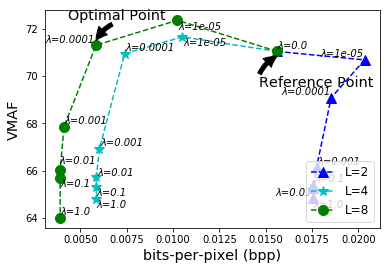

In [22]:
# rl lambda terms
rl_lambda = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]

# plot curves
curve_t.BitrateLossCurves(
    [], None, rl_lambda, None
).plot_curve([
    "./saved_cc/rate_loss_exp/VMAF_2.npy",
    "./saved_cc/rate_loss_exp/VMAF_4.npy",
    "./saved_cc/rate_loss_exp/VMAF_8.npy"
])

**DataLoader**

In [2]:
# def Video Dataloader
vdls = VideoDataLoaders(
    b_s=1, 
    f_s=(320, 640), 
    n_gop=26, 
    nvvl=False, 
    vid_ext='.mp4', 
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

**Load Model**

In [3]:
# def Video Autoencoder
rl_bf_video_auto = BFrameVideoAuto(
    bnd=8,
    multiscale=True
)

# fine tune bitrate
rl_bf_video_auto.fine_tune_bitrate(L=8)

# load model weights
rl_bf_video_auto.load_model("./saved_models/BFrameVideoAuto/Multiscale/8bnd/fine_tuned/BFrameVideoAuto.pt")
ev = EvalVideoModel(rl_bf_video_auto, vdls, standard_epe=False)

**Bit Heat Map Plot**

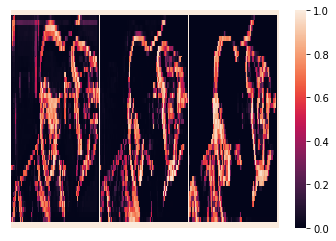

In [4]:
# display compressed vs reference frames
ev.disp_bit_heatmaps(dataset="valid")

# Standard Block Motion Estimation and Compensation

**Exhaustive Search (ES)**

In [5]:
from video_codec import EvalMVC

# evaluate Exhaustive Search (ES)
ev_es = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="ES", 
    mb_size=16, 
    search_dist=7
)

ev_es.display_avg_stats()

Bpp  : 0.01084528962290027
PSNR : 16.348614987680467
SSIM : 0.8503439426422119
VMAF : 44.63794928389827
EPE  : 0.4508008360862732
Time (sec) : 11.348345615370278


**Three Step Search (TSS)**

In [7]:
from video_codec import EvalMVC

# evaluate Three Step Search (TSS)
ev_tss = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="3SS", 
    mb_size=16, 
    search_dist=7
)

ev_tss.display_avg_stats()

Bpp  : 0.010805812586306373
PSNR : 16.371392884496917
SSIM : 0.8511433601379395
VMAF : 44.80819861864405
EPE  : 0.45839357376098633
Time (sec) : 1.532558727709545


**New Three Step Search (NTSS)**

In [6]:
from video_codec import EvalMVC

# evaluate New Three Step Search (NTSS)
ev_ntss = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="N3SS", 
    mb_size=16, 
    search_dist=7
)

ev_ntss.display_avg_stats()

Bpp  : 0.010695465309567947
PSNR : 16.348336878469436
SSIM : 0.851489245891571
VMAF : 44.762505805084714
EPE  : 0.4500148892402649
Time (sec) : 1.1757741397299992


**Simple and Efficient Search (SES)**

In [5]:
from video_codec import EvalMVC

# evaluate Simple and Efficient Search (SES)
ev_ds = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="SE3SS", 
    mb_size=16, 
    search_dist=7
)

ev_ds.display_avg_stats()

Bpp  : 0.006787412334008015
PSNR : 15.79967544038417
SSIM : 0.8456442356109619
VMAF : 40.94133457203391
EPE  : 0.433091402053833
Time (sec) : 0.9633520170612166


**Four Step Search (FSS)**

In [4]:
from video_codec import EvalMVC

# evaluate Four Step Search (FSS)
ev_fss = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="4SS", 
    mb_size=16, 
    search_dist=7
)

ev_fss.display_avg_stats()

Bpp  : 0.007709076444981458
PSNR : 16.29324743303202
SSIM : 0.8517541289329529
VMAF : 44.76818085593216
EPE  : 0.4734130799770355
Time (sec) : 1.0073124575399068


**Diamond Search (DS)**

In [3]:
from video_codec import EvalMVC

# evaluate Diamond Search (DS)
ev_ds = EvalMVC(
    video_dir="~/Videos/hollywood/test/", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="DS", 
    mb_size=16, 
    search_dist=7
)
ev_ds.display_avg_stats()

Bpp  : 0.010023701739368947
PSNR : 15.698714983665337
SSIM : 0.8159193992614746
VMAF : 37.89803281355932
EPE  : 0.5090603232383728
Time (sec) : 0.7696276196324013


**Adaptive Rood Pattern Search (ARPS)**

In [9]:
from video_codec import EvalMVC

# evaluate Adaptive Rood Pattern Search (ARPS)
ev_arp = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="ARPS", 
    mb_size=16, 
    search_dist=7
)

ev_arp.display_avg_stats()

Bpp  : 0.00973914564377459
PSNR : 15.662746292049603
SSIM : 0.8155364394187927
VMAF : 37.89305063135592
EPE  : 0.49193283915519714
Time (sec) : 0.6321978793002002


In [2]:
from video_codec import EvalMVC
print("ESS ********************")
# evaluate Exhaustive Search (ES)
ev_es = EvalMVC(
    video_dir="~/Videos/hollywood/test", 
    vid_ext="mp4",
    frame_size=(224, 320), 
    num_frames=17,
    method="ES", 
    mb_size=8, 
    search_dist=7
)

ev_es.display_avg_stats()

ESS ********************
Bpp  : 0.05825606154471856
PSNR : 19.446509272365248
SSIM : 0.9006776809692383
VMAF : 62.973122279661006
EPE  : 0.4006761908531189
Time (sec) : 46.322017972739374


## Compression Curves

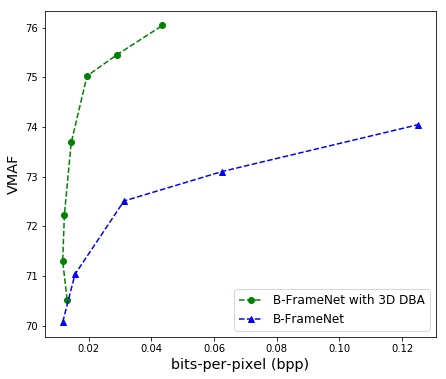

In [7]:
cc = curve_t.CompressionCurves(
    [
        "./saved_cc/dba_exp/B-FrameNet with 3D DBA_VMAF.npy",
        "./saved_cc/dba_exp/B-FrameNet_VMAF.npy"
    ]
)
cc.disp_curves(save_fig=True)

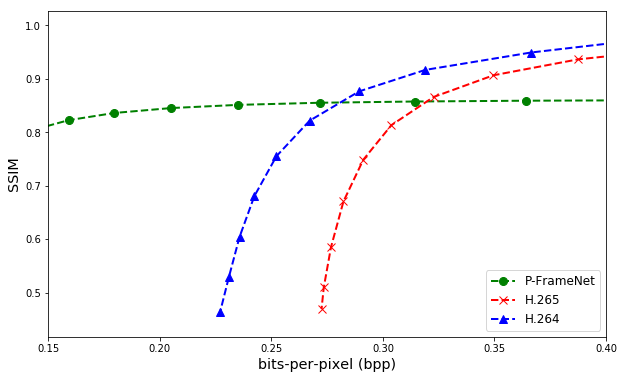

In [4]:
cc = curve_t.CompressionCurves(
    [
        "./saved_cc/pf_64x64_vtl/P-FrameNet_SSIM.npy",
        "./saved_cc/pf_64x64_vtl/H.265_SSIM.npy",
        "./saved_cc/pf_64x64_vtl/H.264_SSIM.npy",
    ]
)
cc.disp_curves(save_fig=True)

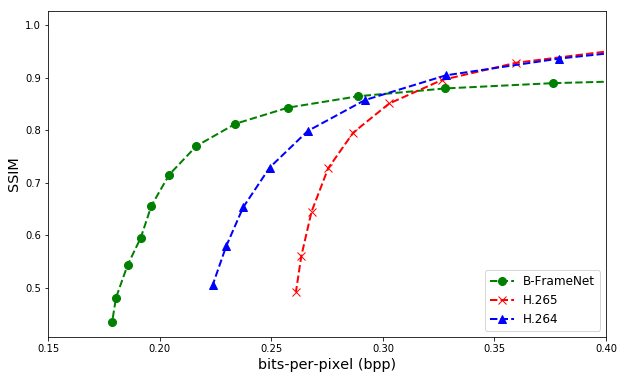

In [2]:
cc = curve_t.CompressionCurves(
    [
        "./saved_cc/bf_64x64_vtl/B-FrameNet_SSIM.npy",
        "./saved_cc/bf_64x64_vtl/H.265_SSIM.npy",
        "./saved_cc/bf_64x64_vtl/H.264_SSIM.npy",
    ]
)
cc.disp_curves(save_fig=True)

**Load B-Frame Net**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


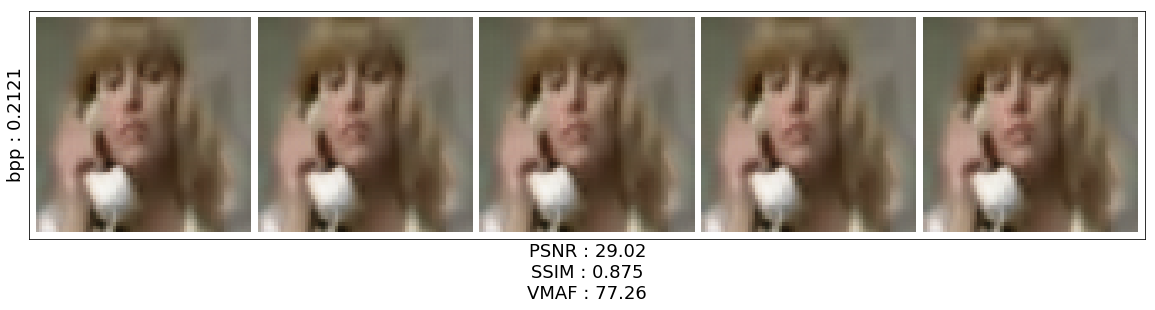

In [2]:
# 64 x 64 WILD & VTL
vdls = VideoDataLoaders(
    b_s=1,
    f_s=(64, 64),
    n_gop=18,
    nvvl=False,
    vid_ext='.mp4',
    root_dir='~/Videos/hollywood',
    color_space='RGB'
)

bf_video_auto = BFrameVideoAuto(
    bnd=8,
    multiscale=True
)
bf_video_auto.fine_tune_bitrate(L=8)

# load model weights
bf_video_auto.load_model("./saved_models/BFrameVideoAuto/Multiscale/8bnd/fine_tuned/BFrameVideoAuto.pt")
ev = EvalVideoModel(bf_video_auto, vdls, if_codec="libx264", standard_epe=False)

ev.disp_comp_frames(dataset="test", q=28, frames_start=8, frame_end=13)

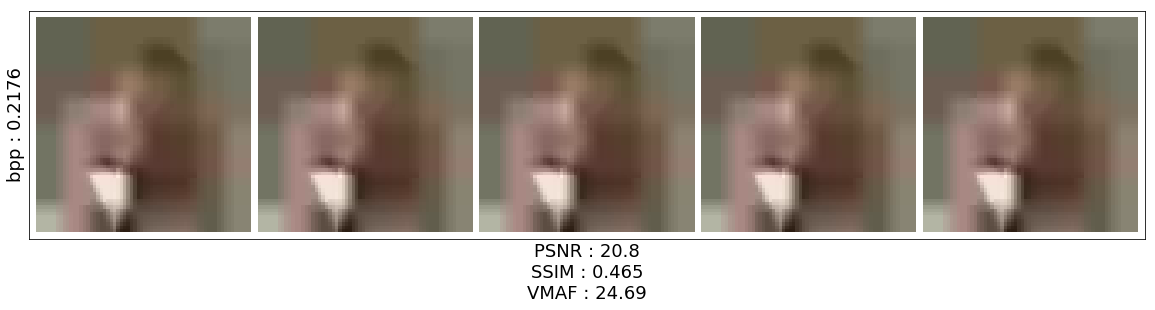

In [3]:
from video_codec import VideoCodec

codec = VideoCodec(
    codec="libx264", 
    n_gop=18, 
    f_s=(64,64), 
    root_dir="~/Videos/hollywood/test", 
    vid_ext='mp4'
)

codec.disp_comp_frames(q=52, fr_start=8, fr_end=13)

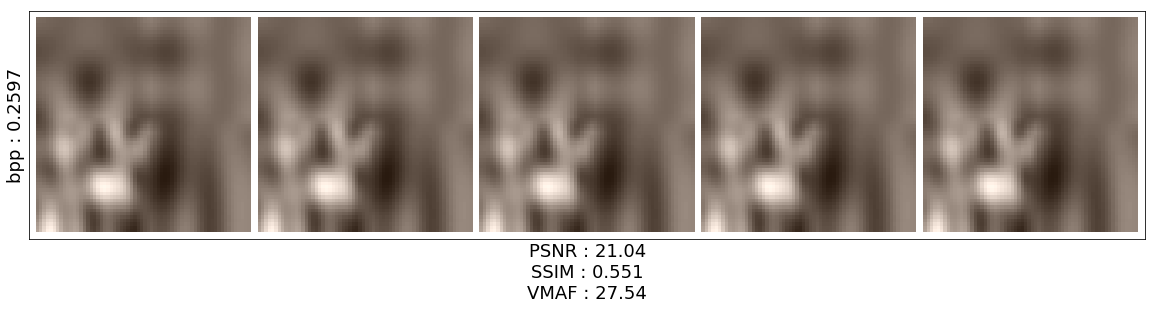

In [4]:
from video_codec import VideoCodec

codec = VideoCodec(
    codec="libx265", 
    n_gop=18, 
    f_s=(64,64), 
    root_dir="~/Videos/hollywood/test", 
    vid_ext='mp4'
)

codec.disp_comp_frames(q=51, fr_start=8, fr_end=13)